In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import time
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler


In [9]:
def read_metrics(filename):
    metrics_dict = {}
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            for part in parts:
                key, value = part.split(':')
                metrics_dict[key] = int(value)
    return metrics_dict


def update_graph(ax, metric_name, metric_values):
    ax.clear()
    ax.plot(metric_values, marker='o')
    ax.set_title(metric_name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid()
    
def update_graphs(frame):
    # Load and update the data from the file
    metrics_dict = read_metrics('../../build/performance/performance_metrics.csv')

    # Update the metric values
    empty_reads_values.append(metrics_dict['Empty Reads Duration'])
    non_empty_reads_values.append(metrics_dict['Read Duration'])
    range_queries_values.append(metrics_dict['Range Reads Duration'])
    write_queries_values.append(metrics_dict['Write Duration'])

    # Update the graphs
    update_graph(ax_empty_reads, 'Empty Reads', empty_reads_values)
    update_graph(ax_non_empty_reads, 'Non-Empty Reads', non_empty_reads_values)
    update_graph(ax_range_queries, 'Range Queries', range_queries_values)
    update_graph(ax_write_queries, 'Write Queries', write_queries_values)



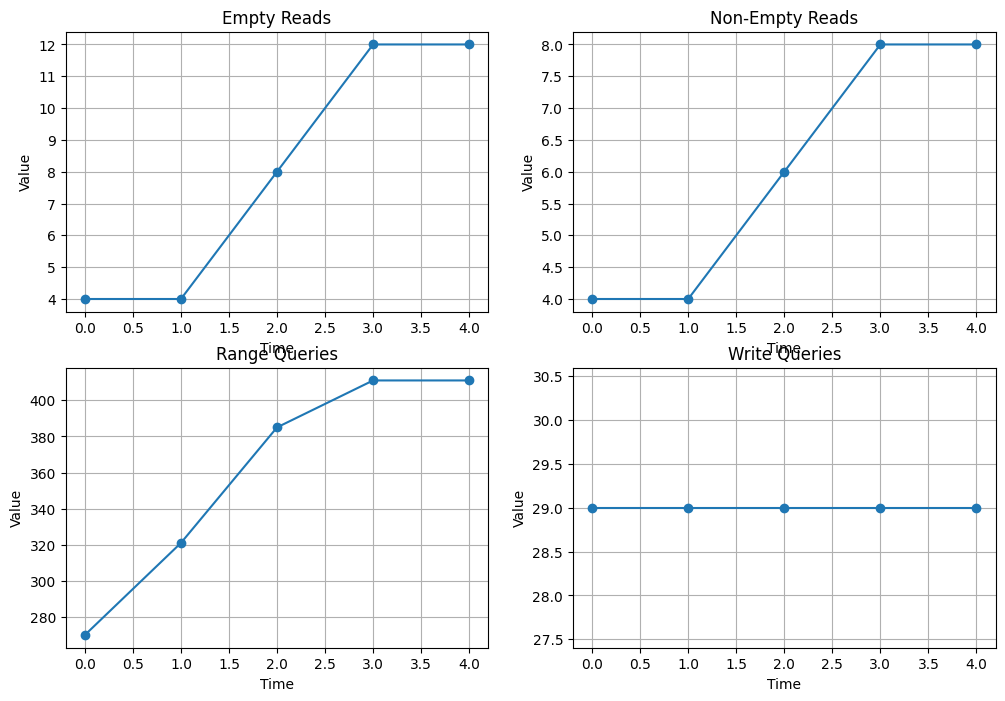

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax_empty_reads, ax_non_empty_reads, ax_range_queries, ax_write_queries = axs.flatten()

# Initialize empty lists to store metric values
empty_reads_values = []
non_empty_reads_values = []
range_queries_values = []
write_queries_values = []
last_read_position =0
# Set the polling interval in seconds (adjust as needed)
polling_interval = 1

# Function to check for changes in the metrics file
def poll_metrics_file():
    global last_read_position
    
    with open('../../build/performance/performance_metrics.csv', 'a') as file:
        pass 

    with open('../../build/performance/performance_metrics.csv', 'r') as file:
        file.seek(last_read_position)
        for line in file:
#             print(line)
            parts = line.strip().split(',')
            for part in parts:
                key, value = part.split(':')
                if key == 'Empty Reads Duration':
                    empty_reads_values.append(int(value))
#                     print(value)
                elif key == 'Read Duration':
                    non_empty_reads_values.append(int(value))
#                     print(value)
                elif key == 'Range Reads Duration':
                    range_queries_values.append(int(value))
#                     print(value)
                elif key == 'Write Duration':
                    write_queries_values.append(int(value))
#                     print(value)
        last_read_position = file.tell()

# Start polling for changes
try:
    while True:
        poll_metrics_file()

        # Update the graphs
#         update_graph(ax_empty_reads, 'Empty Reads', empty_reads_values)
#         update_graph(ax_non_empty_reads, 'Non-Empty Reads', non_empty_reads_values)
#         update_graph(ax_range_queries, 'Range Queries', range_queries_values)
#         update_graph(ax_write_queries, 'Write Queries', write_queries_values)

#         time.sleep(polling_interval)
        ani = FuncAnimation(fig, update_graphs, interval=1000)
        
except KeyboardInterrupt:
    pass

In [17]:
import dash
import dash_core_components as dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import time

# Create a Dash application
app = dash.Dash(__name__)

# Layout of the web application
app.layout = html.Div([
    dcc.Graph(id='empty-reads-graph', animate=True),
    dcc.Graph(id='non-empty-reads-graph', animate=True),
    dcc.Graph(id='range-queries-graph', animate=True),
    dcc.Graph(id='write-queries-graph', animate=True),
])

# Create an initial empty DataFrame
df = pd.DataFrame({
    'Time': [],
    'Empty Reads Duration': [],
    'Read Duration': [],
    'Range Reads Duration': [],
    'Write Duration': []
})

# Callback function to update the graphs
@app.callback(
    [Output('empty-reads-graph', 'figure'),
     Output('non-empty-reads-graph', 'figure'),
     Output('range-queries-graph', 'figure'),
     Output('write-queries-graph', 'figure')],
    [Input('interval-component', 'n_intervals')]
)
def update_graphs(n):
    global df

    # Load and update the data from the file (your read_metrics function)
    metrics_dict = read_metrics('../../build/performance/performance_metrics.csv')

    # Append the new data to the DataFrame
    new_data = {
        'Time': time.strftime('%H:%M:%S'),
        'Empty Reads Duration': metrics_dict['Empty Reads Duration'],
        'Read Duration': metrics_dict['Read Duration'],
        'Range Reads Duration': metrics_dict['Range Reads Duration'],
        'Write Duration': metrics_dict['Write Duration']
    }
    df = df.append(new_data, ignore_index=True)

    # Create the graph traces
    empty_reads_trace = go.Scatter(x=df['Time'], y=df['Empty Reads Duration'], name='Empty Reads Duration', mode='lines+markers')
    non_empty_reads_trace = go.Scatter(x=df['Time'], y=df['Read Duration'], name='Read Duration', mode='lines+markers')
    range_queries_trace = go.Scatter(x=df['Time'], y=df['Range Reads Duration'], name='Range Reads Duration', mode='lines+markers')
    write_queries_trace = go.Scatter(x=df['Time'], y=df['Write Duration'], name='Write Duration', mode='lines+markers')

    # Create the figure for each graph
    empty_reads_figure = {'data': [empty_reads_trace], 'layout': {'title': 'Empty Reads Duration'}}
    non_empty_reads_figure = {'data': [non_empty_reads_trace], 'layout': {'title': 'Read Duration'}}
    range_queries_figure = {'data': [range_queries_trace], 'layout': {'title': 'Range Reads Duration'}}
    write_queries_figure = {'data': [write_queries_trace], 'layout': {'title': 'Write Duration'}}

    return empty_reads_figure, non_empty_reads_figure, range_queries_figure, write_queries_figure

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)
